# Analyse des sentiments sur Twitter



### Introduction

#### Traitement du langage naturel (NLP) : 
Est une discipline de l'informatique, de l'intelligence artificielle et de la linguistique qui s'intéresse à la création de modèles informatiques qui traitent et comprennent le langage naturel. Ceux-ci incluent : faire comprendre à l'ordinateur le regroupement sémantique des mots (par exemple, le chat et le chien sont sémantiquement plus similaires que le chat et la cuillère), la synthèse vocale, la traduction linguistique et bien d'autres encore.

#### Analyse des sentiments :
Il s'agit de l'interprétation et de la classification des émotions (positives, négatives et neutres) dans les données textuelles à l'aide de techniques d'analyse de texte. L'analyse des sentiments permet aux organisations d'identifier le sentiment du public à l'égard de certains mots ou sujets.

Dans ce NoteBook , On va voir commenr développer un modèle d'analyse des sentiments pour classer un tweet comme positif ou négatif.

#### Table des matières


#### 1. Importation des bibliothèques

Pour faire une classification de texte ( tweet) il faut mettre en place une chaîne de traitement d'apprentissage automatique

In [21]:
# utilitaires
import re  # Opérations d'expressions régulières pour la manipulation de chaînes de caractères.
import pickle  #  Utilisé pour sérialiser et désérialiser des objets Python
import numpy as np  # Importation de la bibliothéque NumPy pour le support des tableaux et opérations mathématiques
import pandas as pd  # Importation de la bibliotheque Pandas pour la manipulation des données tabulaires

# tracé
import seaborn as sns  # Bibliothèque de visualisation de données basée sur Matplotlib
from wordcloud import WordCloud  # Bibliothèque pour créer des nuages Nuage de mots pour la visualisation de texte
import matplotlib.pyplot as plt  # Une bibliothèque complète pour créer des visualisations statiques, animées et interactives en Python

# nltk
from nltk.stem import WordNetLemmatizer  # Module NLTK pour la lemmatisation des mots

# sklearn
from sklearn.svm import LinearSVC  # Classification par vecteur de support linéaire
from sklearn.naive_bayes import BernoulliNB  # Classifieur Naive Bayes de Bernoulli
from sklearn.linear_model import LogisticRegression  # Régression logistique

from sklearn.model_selection import train_test_split  # Permet la Division des données en ensembles d'entraînement et de test
from sklearn.feature_extraction.text import TfidfVectorizer  # Permet l'Extraction de caractéristiques pour le texte (TF-IDF)
from sklearn.metrics import confusion_matrix, classification_report  # Matrice de confusion et rapport de classification


#### 2. Importation du jeu de données (dataset)

Le jeu de données utilisé est le jeu de données Sentiment140. Il contient 1 600 000 tweets extraits à l'aide de l'API Twitter. Les tweets ont été annotés (0 = Négatif, 4 = Positif) et peuvent être utilisés pour détecter le sentiment.

Les données d'entraînement ne sont pas parfaitement catégorisées car elles ont été créées en étiquetant le texte en fonction de l'emoji présent. Ainsi, tout modèle construit avec ce jeu de données peut avoir une précision inférieure à celle attendue, car le jeu de données n'est pas parfaitement catégorisé.



Il contient les 6 champs suivants :

1. sentiment : la polarité du tweet (0 = négatif, 4 = positif)
2. date : la date du tweet (Sam Mai 16 23:58:44 UTC 2009)
3. flag : La requête (lyx). S'il n'y a pas de requête, alors cette valeur est NO_QUERY.
4. user : l'utilisateur qui a tweeté (robotickilldozr)
5. text : le texte du tweet (Lyx is cool)

Nous avons besoin que des champs sentiment et text.

De plus, on va modifier le champ sentiment de manière qu'il a que deux valeurs qui répresentent le sentiment 0 et 1. (0 = Négatif, 1 = Positif)

In [22]:
# Importation de dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('C:/Users/nourb/Downloads/archive (1)/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)


In [23]:
# Suppression des colonnes inutiles
dataset = dataset[['sentiment','text']]

In [24]:
# Remplacement des valeurs pour faciliter la compréhension
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

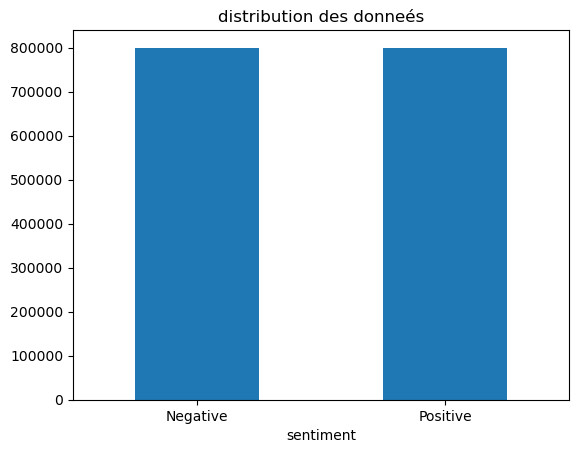

In [25]:
# Ccréation d'un graphique pour visualiser la distribution du jeu de données
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='distribution des donneés',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# extraire les données du jeu de données et les stocker dans deux listes distinctes
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

#### 3. Prétraitement de texte

Le prétraitement de texte est traditionnellement une étape importante pour les tâches de Traitement Automatique du Langage Naturel (NLP). Il transforme le texte en une forme plus digestible afin que les algorithmes d'apprentissage automatique puissent mieux performer.

Les étapes de prétraitement effectuées sont les suivantes :

1. Mise en minuscules : Chaque texte est converti en minuscules.
2. Remplacement des URL : Les liens commençant par "http", "https" ou "www" sont remplacés par "URL".
3. Remplacement des émojis : Remplace les émojis en utilisant un dictionnaire prédéfini contenant les émojis ainsi que leur signification. (par exemple, ":)" devient "EMOJIsmile")
4. Remplacement des noms d'utilisateur : Remplace les @noms_utilisateur par le mot "USER". (par exemple, "@Kaggle" devient "USER")
5. Suppression des caractères non alphabétiques : Remplace les caractères autres que les chiffres et les lettres par un espace.
6. Suppression des lettres consécutives : 3 lettres consécutives ou plus sont remplacées par 2 lettres. (par exemple, "Heyyyy" devient "Heyy")
7. Suppression des mots courts : Les mots de moins de 2 caractères sont supprimés.
8. Suppression des mots vides : Les mots vides sont des mots anglais qui n'ajoutent pas beaucoup de sens à une phrase. Ils peuvent être ignorés sans sacrifier le sens de la phrase. (par exemple, "le", "il", "avoir")
9. Lématisation : La lemmatisation est le processus de conversion d'un mot à sa forme de base. (par exemple, “Great” devient “Good”)

In [26]:
# Définition d'un dictionnaire contenant tous les emojis avec leurs significations.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# Définition d'un ensemble contenant toutes les mots vides en anglais.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']


In [27]:
# Définition de la fonction de prétraitement
def preprocess(textdata):
    processedText = []
    
    # Création du lemmatiseur (WordNetLemmatizer)
    wordLemm = WordNetLemmatizer()
    
    # Définition de motifs regex
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    # Parcours de chaque tweet dans les données textuelles
    for tweet in textdata:
        # Conversion du tweet en minuscules
        tweet = tweet.lower()
        
        # Remplacement de toutes les URL par 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        
        # Remplacement de tous les emojis
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        
        # Remplacement des @NOM_UTILISATEUR par 'USER'
        tweet = re.sub(userPattern,' USER', tweet)
        
        # Remplacement de tous les caractères non alphabétiques
        tweet = re.sub(alphaPattern, " ", tweet)
        
        # Remplacement de 3 lettres consécutives ou plus par 2 lettres
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        # Parcours de chaque mot dans le tweet
        for word in tweet.split():
            # Vérification si le mot n'est pas dans la liste des mots vides
            # et s'il a une longueur supérieure à 1
            if len(word)>1:
                # Lemmatisation du mot
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText



In [28]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 79 seconds


#### 4. Analyse des données

Maintenant, nous allons analyser les données prétraitées pour en obtenir une compréhension. Nous allons générer des nuages de mots pour les tweets positifs et négatifs de notre ensemble de données et voir quels mots sont les plus fréquents

#### Word-Cloud for Negative tweets.


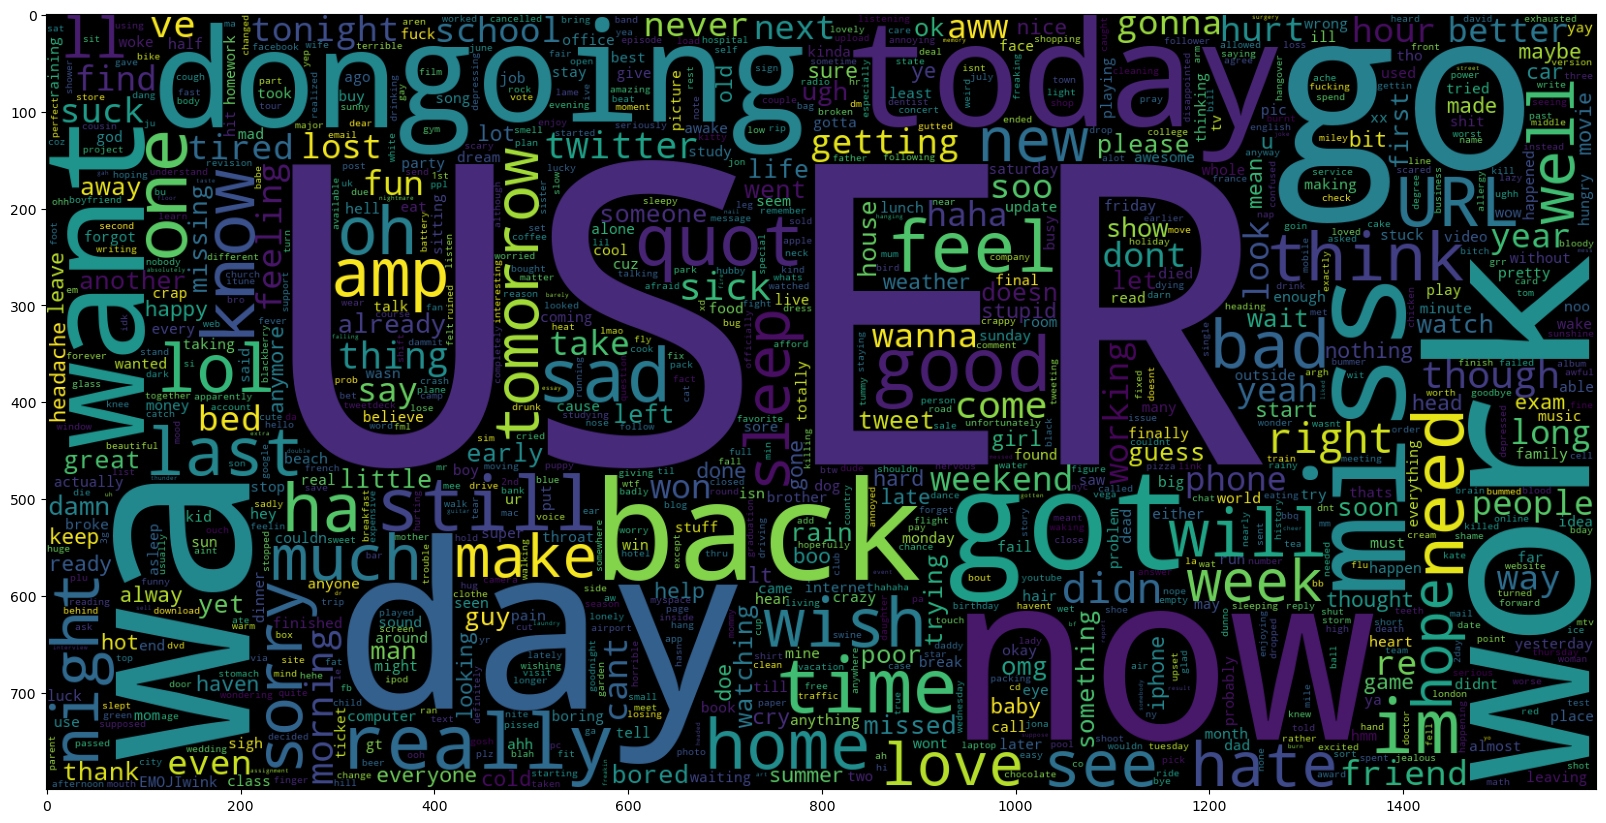

In [29]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

#### Word-Cloud for Positive tweets.


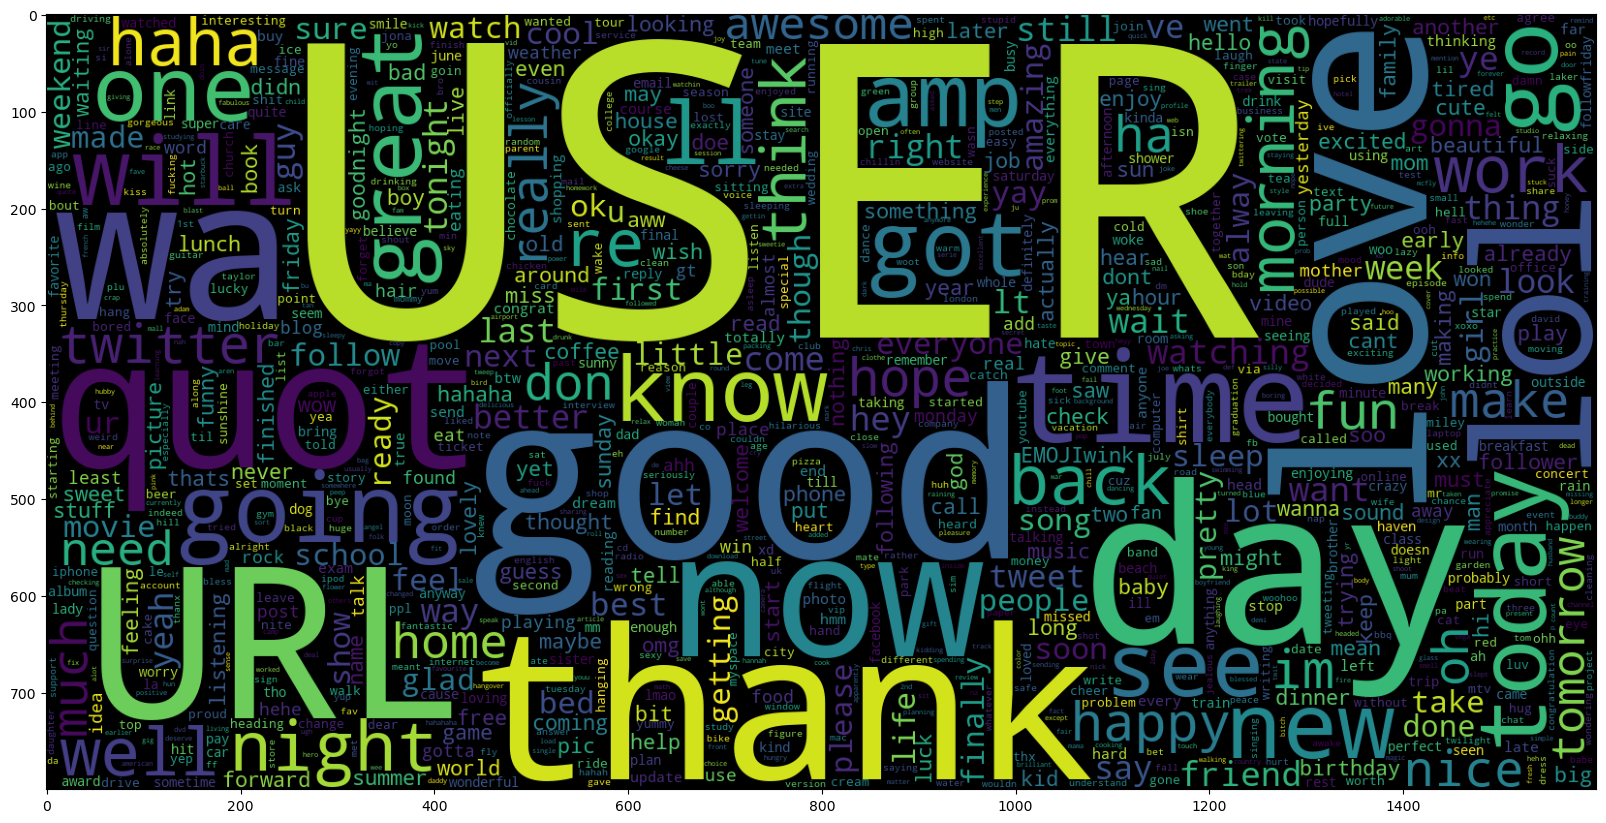

In [30]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

#### 5. Division des données

Les données prétraitées sont divisées en deux ensembles de données :

Données d'entraînement : Il s'agit de l'ensemble de données sur lequel le modèle sera entraîné. Il contient 95 % des données.

Données de test : Il s'agit de l'ensemble de données sur lequel le modèle sera testé. Il contient 5 % des données.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


### TF-IDF Vectoriser

TF-IDF (Term Frequency-Inverse Document Frequency) indique l'importance d'un mot afin de comprendre le document ou l'ensemble de données. Explorons cela avec un exemple. Supposons que vous ayez un ensemble de données où des étudiants écrivent un essai sur le sujet "Ma maison". Dans cet ensemble de données, le mot "a" apparaît de nombreuses fois ; c'est un mot de haute fréquence par rapport aux autres mots de l'ensemble de données. L'ensemble de données contient d'autres mots tels que "home" (maison), "house" (maison), "rooms" (pièces), et ainsi de suite, qui apparaissent moins souvent, donc leur fréquence est plus basse et ils portent plus d'information par rapport au mot "a".
C'est l'intuition derrière TF-IDF.

Le vectoriseur TF-IDF convertit une collection de documents bruts en une matrice de caractéristiques TF-IDF. Le vectoriseur est généralement entraîné uniquement sur l'ensemble de données X_train.

ngram_range est la plage du nombre de mots dans une séquence. Par exemple, "very expensive" est un bi-gramme (2-gramme) qui est considéré comme une fonction supplémentaire séparément de "very" et "expensive" lorsque vous avez une plage de n-gramme de (1,2).

max_features spécifie le nombre de caractéristiques à considérer. Elles sont ordonnées par fréquence des caractéristiques dans l'ensemble du corpus.

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectorizer.fit(X_train)
print(f'Vectorizer fitted.')
print('No. of feature_words: ', len(vectorizer.get_feature_names_out()))


Vectorizer fitted.
No. of feature_words:  500000


### Transformation de l'ensemble de données

Transformation des ensembles de données X_train et X_test en matrices de caractéristiques TF-IDF à l'aide du vectoriseur TF-IDF. 
Ces ensembles de données seront utilisés pour entraîner le modèle et le tester.

In [42]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
print(f'Les donneés sont transformés.')

Les donneés sont transformés.


### Création et évaluation des modèles

Nous créons trois types différents de modèles pour notre problème d'analyse de sentiment :

1. Bernoulli Naive Bayes (BernoulliNB)
2. Classification de Support Vector Linéaire (LinearSVC)
3. Régression Logistique (LR)

Étant donné que notre ensemble de données n'est pas biaisé, c'est-à-dire qu'il contient un nombre égal de prédictions positives et négatives, nous choisissons la précision (Accuracy) comme métrique d'évaluation. De plus, nous générons la matrice de confusion pour comprendre comment notre modèle se comporte dans les deux types de classification.

### Fonction d'évaluation du modèle

In [43]:
def model_Evaluate(model):
    
    # Prédire les valeurs pour l'ensemble de données de test
    y_pred = model.predict(X_test)

    # Afficher les métriques d'évaluation pour l'ensemble de données.
    print(classification_report(y_test, y_pred))
    
    # Calculer et afficher la matrice de confusion
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Négatif', 'Positif']
    group_names = ['Vrai Nég', 'Faux Pos', 'Faux Nég', 'Vrai Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)

    plt.xlabel("Valeurs prédites", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Valeurs réelles", fontdict={'size': 14}, labelpad=10)
    plt.title("Matrice de confusion", fontdict={'size': 18}, pad=20)


### Modèle BernoulliNB

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.80      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



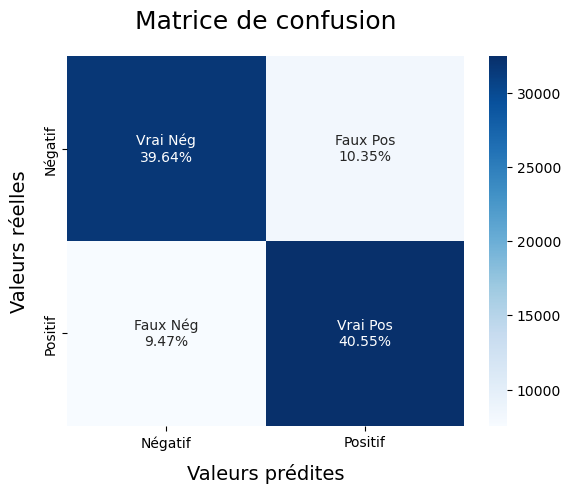

In [44]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

### Modèle LinearSVC

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     39989
           1       0.81      0.83      0.82     40011

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



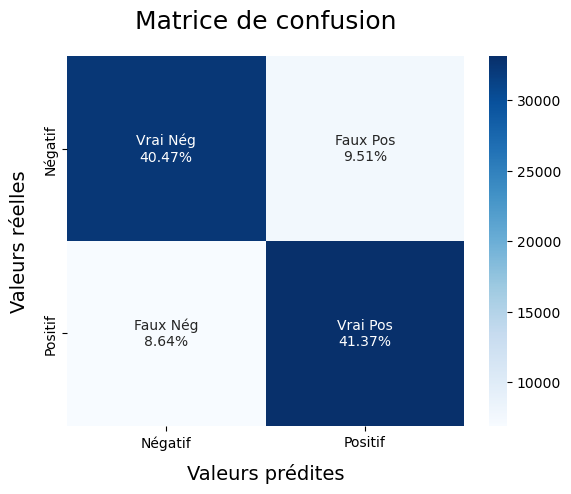

In [45]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

### Modèle de Régression Logistique

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     39989
           1       0.82      0.84      0.83     40011

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



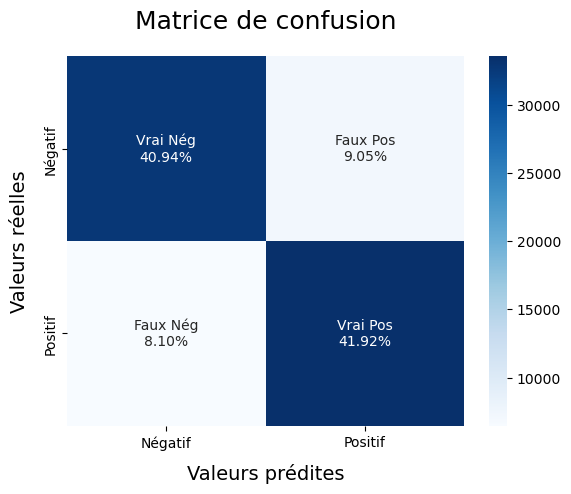

In [46]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

Nous pouvons clairement voir que le modèle de régression logistique performe le mieux parmi tous les modèles que nous avons essayés. Il atteint presque 82 % de précision lors de la classification du sentiment d'un tweet.

Cependant, il convient également de noter que le modèle BernoulliNB est le plus rapide à entraîner et à prédire. Il atteint également une précision de 80 % lors de la classification.

### Sauvegarde des modèles

Nous utilisons PICKLE pour sauvegarder le Vectorizer ainsi que les modèles BernoulliNB et Régression Logistique pour une utilisation ultérieure

In [47]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()